GPU: -1
# dim z: 2
# Minibatch-size: 1200
# epoch: 200

labels shape is (3000, 7840)
l shape is (56, 140)
(x, y) = (57, 14)
ravel l is (7840,)
(56, 140)
l shape is (56, 140)
(x, y) = (36, 17)
ravel l is (7840,)
(56, 140)
l shape is (56, 140)
(x, y) = (27, 18)
ravel l is (7840,)
(56, 140)
l shape is (56, 140)
(x, y) = (72, 41)
ravel l is (7840,)
(56, 140)
l shape is (56, 140)
(x, y) = (117, 20)
ravel l is (7840,)
(56, 140)
l shape is (56, 140)
(x, y) = (118, 24)
ravel l is (7840,)
(56, 140)
l shape is (56, 140)
(x, y) = (118, 23)
ravel l is (7840,)
(56, 140)
l shape is (56, 140)
(x, y) = (113, 30)
ravel l is (7840,)
(56, 140)
l shape is (56, 140)
(x, y) = (116, 38)
ravel l is (7840,)
(56, 140)
l shape is (56, 140)
(x, y) = (37, 34)
ravel l is (7840,)
(56, 140)
l shape is (56, 140)
(x, y) = (42, 18)
ravel l is (7840,)
(56, 140)
l shape is (56, 140)
(x, y) = (44, 38)
ravel l is (7840,)
(56, 140)
l shape is (56, 140)
(x, y) = (19, 37)
ravel l is (7840,)
(56, 140)
l shape is (56, 140)
(x, y

(56, 140)
l shape is (56, 140)
(x, y) = (77, 16)
ravel l is (7840,)
(56, 140)
l shape is (56, 140)
(x, y) = (108, 29)
ravel l is (7840,)
(56, 140)
l shape is (56, 140)
(x, y) = (103, 19)
ravel l is (7840,)
(56, 140)
l shape is (56, 140)
(x, y) = (59, 20)
ravel l is (7840,)
(56, 140)
l shape is (56, 140)
(x, y) = (73, 14)
ravel l is (7840,)
(56, 140)
l shape is (56, 140)
(x, y) = (72, 28)
ravel l is (7840,)
(56, 140)
l shape is (56, 140)
(x, y) = (108, 15)
ravel l is (7840,)
(56, 140)
l shape is (56, 140)
(x, y) = (99, 23)
ravel l is (7840,)
(56, 140)
l shape is (56, 140)
(x, y) = (97, 24)
ravel l is (7840,)
(56, 140)
l shape is (56, 140)
(x, y) = (71, 38)
ravel l is (7840,)
(56, 140)
l shape is (56, 140)
(x, y) = (20, 20)
ravel l is (7840,)
(56, 140)
l shape is (56, 140)
(x, y) = (95, 27)
ravel l is (7840,)
(56, 140)
l shape is (56, 140)
(x, y) = (76, 15)
ravel l is (7840,)
(56, 140)
l shape is (56, 140)
(x, y) = (105, 33)
ravel l is (7840,)
(56, 140)
l shape is (56, 140)
(x, y) = (14,

ravel l is (7840,)
(56, 140)
l shape is (56, 140)
(x, y) = (81, 36)
ravel l is (7840,)
(56, 140)
l shape is (56, 140)
(x, y) = (75, 17)
ravel l is (7840,)
(56, 140)
l shape is (56, 140)
(x, y) = (111, 18)
ravel l is (7840,)
(56, 140)
l shape is (56, 140)
(x, y) = (103, 36)
ravel l is (7840,)
(56, 140)
l shape is (56, 140)
(x, y) = (59, 35)
ravel l is (7840,)
(56, 140)
l shape is (56, 140)
(x, y) = (54, 33)
ravel l is (7840,)
(56, 140)
l shape is (56, 140)
(x, y) = (99, 15)
ravel l is (7840,)
(56, 140)
l shape is (56, 140)
(x, y) = (69, 16)
ravel l is (7840,)
(56, 140)
l shape is (56, 140)
(x, y) = (62, 37)
ravel l is (7840,)
(56, 140)
l shape is (56, 140)
(x, y) = (55, 34)
ravel l is (7840,)
(56, 140)
l shape is (56, 140)
(x, y) = (75, 40)
ravel l is (7840,)
(56, 140)
l shape is (56, 140)
(x, y) = (111, 14)
ravel l is (7840,)
(56, 140)
l shape is (56, 140)
(x, y) = (50, 39)
ravel l is (7840,)
(56, 140)
l shape is (56, 140)
(x, y) = (65, 15)
ravel l is (7840,)
(56, 140)
l shape is (56, 

ravel l is (7840,)
(56, 140)
l shape is (56, 140)
(x, y) = (88, 17)
ravel l is (7840,)
(56, 140)
l shape is (56, 140)
(x, y) = (66, 34)
ravel l is (7840,)
(56, 140)
l shape is (56, 140)
(x, y) = (34, 21)
ravel l is (7840,)
(56, 140)
l shape is (56, 140)
(x, y) = (90, 19)
ravel l is (7840,)
(56, 140)
l shape is (56, 140)
(x, y) = (84, 30)
ravel l is (7840,)
(56, 140)
l shape is (56, 140)
(x, y) = (114, 20)
ravel l is (7840,)
(56, 140)
l shape is (56, 140)
(x, y) = (94, 20)
ravel l is (7840,)
(56, 140)
l shape is (56, 140)
(x, y) = (112, 19)
ravel l is (7840,)
(56, 140)
l shape is (56, 140)
(x, y) = (28, 20)
ravel l is (7840,)
(56, 140)
l shape is (56, 140)
(x, y) = (55, 18)
ravel l is (7840,)
(56, 140)
l shape is (56, 140)
(x, y) = (31, 25)
ravel l is (7840,)
(56, 140)
l shape is (56, 140)
(x, y) = (16, 14)
ravel l is (7840,)
(56, 140)
l shape is (56, 140)
(x, y) = (37, 16)
ravel l is (7840,)
(56, 140)
l shape is (56, 140)
(x, y) = (96, 34)
ravel l is (7840,)
(56, 140)
l shape is (56, 1

l shape is (56, 140)
(x, y) = (102, 34)
ravel l is (7840,)
(56, 140)
l shape is (56, 140)
(x, y) = (82, 27)
ravel l is (7840,)
(56, 140)
l shape is (56, 140)
(x, y) = (121, 14)
ravel l is (7840,)
(56, 140)
l shape is (56, 140)
(x, y) = (51, 29)
ravel l is (7840,)
(56, 140)
l shape is (56, 140)
(x, y) = (100, 37)
ravel l is (7840,)
(56, 140)
l shape is (56, 140)
(x, y) = (93, 40)
ravel l is (7840,)
(56, 140)
l shape is (56, 140)
(x, y) = (23, 19)
ravel l is (7840,)
(56, 140)
l shape is (56, 140)
(x, y) = (36, 33)
ravel l is (7840,)
(56, 140)
l shape is (56, 140)
(x, y) = (53, 14)
ravel l is (7840,)
(56, 140)
l shape is (56, 140)
(x, y) = (66, 15)
ravel l is (7840,)
(56, 140)
l shape is (56, 140)
(x, y) = (42, 18)
ravel l is (7840,)
(56, 140)
l shape is (56, 140)
(x, y) = (70, 24)
ravel l is (7840,)
(56, 140)
l shape is (56, 140)
(x, y) = (51, 21)
ravel l is (7840,)
(56, 140)
l shape is (56, 140)
(x, y) = (87, 37)
ravel l is (7840,)
(56, 140)
l shape is (56, 140)
(x, y) = (49, 21)
ravel 

l shape is (56, 140)
(x, y) = (66, 22)
ravel l is (7840,)
(56, 140)
l shape is (56, 140)
(x, y) = (121, 25)
ravel l is (7840,)
(56, 140)
l shape is (56, 140)
(x, y) = (47, 33)
ravel l is (7840,)
(56, 140)
l shape is (56, 140)
(x, y) = (47, 41)
ravel l is (7840,)
(56, 140)
l shape is (56, 140)
(x, y) = (29, 15)
ravel l is (7840,)
(56, 140)
l shape is (56, 140)
(x, y) = (17, 30)
ravel l is (7840,)
(56, 140)
l shape is (56, 140)
(x, y) = (118, 31)
ravel l is (7840,)
(56, 140)
l shape is (56, 140)
(x, y) = (47, 29)
ravel l is (7840,)
(56, 140)
l shape is (56, 140)
(x, y) = (112, 19)
ravel l is (7840,)
(56, 140)
l shape is (56, 140)
(x, y) = (15, 28)
ravel l is (7840,)
(56, 140)
l shape is (56, 140)
(x, y) = (30, 39)
ravel l is (7840,)
(56, 140)
l shape is (56, 140)
(x, y) = (100, 33)
ravel l is (7840,)
(56, 140)
l shape is (56, 140)
(x, y) = (110, 29)
ravel l is (7840,)
(56, 140)
l shape is (56, 140)
(x, y) = (64, 16)
ravel l is (7840,)
(56, 140)
l shape is (56, 140)
(x, y) = (43, 38)
rave

l shape is (56, 140)
(x, y) = (79, 27)
ravel l is (7840,)
(56, 140)
l shape is (56, 140)
(x, y) = (19, 30)
ravel l is (7840,)
(56, 140)
l shape is (56, 140)
(x, y) = (45, 18)
ravel l is (7840,)
(56, 140)
l shape is (56, 140)
(x, y) = (46, 35)
ravel l is (7840,)
(56, 140)
l shape is (56, 140)
(x, y) = (40, 15)
ravel l is (7840,)
(56, 140)
l shape is (56, 140)
(x, y) = (63, 36)
ravel l is (7840,)
(56, 140)
l shape is (56, 140)
(x, y) = (29, 19)
ravel l is (7840,)
(56, 140)
l shape is (56, 140)
(x, y) = (57, 26)
ravel l is (7840,)
(56, 140)
l shape is (56, 140)
(x, y) = (118, 41)
ravel l is (7840,)
(56, 140)
l shape is (56, 140)
(x, y) = (16, 29)
ravel l is (7840,)
(56, 140)
l shape is (56, 140)
(x, y) = (91, 22)
ravel l is (7840,)
(56, 140)
l shape is (56, 140)
(x, y) = (48, 23)
ravel l is (7840,)
(56, 140)
l shape is (56, 140)
(x, y) = (101, 24)
ravel l is (7840,)
(56, 140)
l shape is (56, 140)
(x, y) = (51, 20)
ravel l is (7840,)
(56, 140)
l shape is (56, 140)
(x, y) = (114, 35)
ravel 

(56, 140)
l shape is (56, 140)
(x, y) = (91, 34)
ravel l is (7840,)
(56, 140)
l shape is (56, 140)
(x, y) = (97, 19)
ravel l is (7840,)
(56, 140)
l shape is (56, 140)
(x, y) = (30, 36)
ravel l is (7840,)
(56, 140)
l shape is (56, 140)
(x, y) = (95, 41)
ravel l is (7840,)
(56, 140)
l shape is (56, 140)
(x, y) = (65, 34)
ravel l is (7840,)
(56, 140)
l shape is (56, 140)
(x, y) = (97, 30)
ravel l is (7840,)
(56, 140)
l shape is (56, 140)
(x, y) = (82, 14)
ravel l is (7840,)
(56, 140)
l shape is (56, 140)
(x, y) = (39, 20)
ravel l is (7840,)
(56, 140)
l shape is (56, 140)
(x, y) = (19, 28)
ravel l is (7840,)
(56, 140)
l shape is (56, 140)
(x, y) = (113, 15)
ravel l is (7840,)
(56, 140)
l shape is (56, 140)
(x, y) = (54, 14)
ravel l is (7840,)
(56, 140)
l shape is (56, 140)
(x, y) = (103, 29)
ravel l is (7840,)
(56, 140)
l shape is (56, 140)
(x, y) = (101, 16)
ravel l is (7840,)
(56, 140)
l shape is (56, 140)
(x, y) = (42, 30)
ravel l is (7840,)
(56, 140)
l shape is (56, 140)
(x, y) = (96, 

(56, 140)
l shape is (56, 140)
(x, y) = (49, 32)
ravel l is (7840,)
(56, 140)
l shape is (56, 140)
(x, y) = (91, 22)
ravel l is (7840,)
(56, 140)
l shape is (56, 140)
(x, y) = (38, 39)
ravel l is (7840,)
(56, 140)
l shape is (56, 140)
(x, y) = (58, 25)
ravel l is (7840,)
(56, 140)
l shape is (56, 140)
(x, y) = (23, 17)
ravel l is (7840,)
(56, 140)
l shape is (56, 140)
(x, y) = (99, 16)
ravel l is (7840,)
(56, 140)
l shape is (56, 140)
(x, y) = (49, 22)
ravel l is (7840,)
(56, 140)
l shape is (56, 140)
(x, y) = (83, 29)
ravel l is (7840,)
(56, 140)
l shape is (56, 140)
(x, y) = (83, 35)
ravel l is (7840,)
(56, 140)
l shape is (56, 140)
(x, y) = (64, 30)
ravel l is (7840,)
(56, 140)
l shape is (56, 140)
(x, y) = (58, 19)
ravel l is (7840,)
(56, 140)
l shape is (56, 140)
(x, y) = (104, 40)
ravel l is (7840,)
(56, 140)
l shape is (56, 140)
(x, y) = (24, 35)
ravel l is (7840,)
(56, 140)
l shape is (56, 140)
(x, y) = (46, 20)
ravel l is (7840,)
(56, 140)
l shape is (56, 140)
(x, y) = (22, 29

l shape is (56, 140)
(x, y) = (81, 33)
ravel l is (7840,)
(56, 140)
l shape is (56, 140)
(x, y) = (120, 16)
ravel l is (7840,)
(56, 140)
l shape is (56, 140)
(x, y) = (76, 15)
ravel l is (7840,)
(56, 140)
l shape is (56, 140)
(x, y) = (34, 32)
ravel l is (7840,)
(56, 140)
l shape is (56, 140)
(x, y) = (21, 31)
ravel l is (7840,)
(56, 140)
l shape is (56, 140)
(x, y) = (108, 20)
ravel l is (7840,)
(56, 140)
l shape is (56, 140)
(x, y) = (40, 22)
ravel l is (7840,)
(56, 140)
l shape is (56, 140)
(x, y) = (93, 35)
ravel l is (7840,)
(56, 140)
l shape is (56, 140)
(x, y) = (112, 24)
ravel l is (7840,)
(56, 140)
l shape is (56, 140)
(x, y) = (15, 36)
ravel l is (7840,)
(56, 140)
l shape is (56, 140)
(x, y) = (102, 38)
ravel l is (7840,)
(56, 140)
l shape is (56, 140)
(x, y) = (53, 41)
ravel l is (7840,)
(56, 140)
l shape is (56, 140)
(x, y) = (20, 40)
ravel l is (7840,)
(56, 140)
l shape is (56, 140)
(x, y) = (39, 28)
ravel l is (7840,)
(56, 140)
l shape is (56, 140)
(x, y) = (111, 18)
rave

ravel l is (7840,)
(56, 140)
l shape is (56, 140)
(x, y) = (77, 32)
ravel l is (7840,)
(56, 140)
l shape is (56, 140)
(x, y) = (19, 32)
ravel l is (7840,)
(56, 140)
l shape is (56, 140)
(x, y) = (53, 15)
ravel l is (7840,)
(56, 140)
l shape is (56, 140)
(x, y) = (108, 27)
ravel l is (7840,)
(56, 140)
l shape is (56, 140)
(x, y) = (31, 22)
ravel l is (7840,)
(56, 140)
l shape is (56, 140)
(x, y) = (47, 38)
ravel l is (7840,)
(56, 140)
l shape is (56, 140)
(x, y) = (28, 35)
ravel l is (7840,)
(56, 140)
l shape is (56, 140)
(x, y) = (80, 23)
ravel l is (7840,)
(56, 140)
l shape is (56, 140)
(x, y) = (66, 37)
ravel l is (7840,)
(56, 140)
l shape is (56, 140)
(x, y) = (105, 14)
ravel l is (7840,)
(56, 140)
l shape is (56, 140)
(x, y) = (105, 30)
ravel l is (7840,)
(56, 140)
l shape is (56, 140)
(x, y) = (98, 27)
ravel l is (7840,)
(56, 140)
l shape is (56, 140)
(x, y) = (94, 37)
ravel l is (7840,)
(56, 140)
l shape is (56, 140)
(x, y) = (119, 31)
ravel l is (7840,)
(56, 140)
l shape is (56,

l shape is (56, 140)
(x, y) = (121, 15)
ravel l is (7840,)
(56, 140)
l shape is (56, 140)
(x, y) = (28, 25)
ravel l is (7840,)
(56, 140)
l shape is (56, 140)
(x, y) = (125, 23)
ravel l is (7840,)
(56, 140)
l shape is (56, 140)
(x, y) = (87, 19)
ravel l is (7840,)
(56, 140)
l shape is (56, 140)
(x, y) = (53, 20)
ravel l is (7840,)
(56, 140)
l shape is (56, 140)
(x, y) = (50, 26)
ravel l is (7840,)
(56, 140)
l shape is (56, 140)
(x, y) = (114, 28)
ravel l is (7840,)
(56, 140)
l shape is (56, 140)
(x, y) = (65, 36)
ravel l is (7840,)
(56, 140)
l shape is (56, 140)
(x, y) = (45, 24)
ravel l is (7840,)
(56, 140)
l shape is (56, 140)
(x, y) = (57, 39)
ravel l is (7840,)
(56, 140)
l shape is (56, 140)
(x, y) = (99, 19)
ravel l is (7840,)
(56, 140)
l shape is (56, 140)
(x, y) = (92, 31)
ravel l is (7840,)
(56, 140)
l shape is (56, 140)
(x, y) = (94, 15)
ravel l is (7840,)
(56, 140)
l shape is (56, 140)
(x, y) = (104, 14)
ravel l is (7840,)
(56, 140)
l shape is (56, 140)
(x, y) = (66, 37)
ravel

ravel l is (7840,)
(56, 140)
l shape is (56, 140)
(x, y) = (21, 28)
ravel l is (7840,)
(56, 140)
l shape is (56, 140)
(x, y) = (24, 19)
ravel l is (7840,)
(56, 140)
l shape is (56, 140)
(x, y) = (98, 22)
ravel l is (7840,)
(56, 140)
l shape is (56, 140)
(x, y) = (57, 20)
ravel l is (7840,)
(56, 140)
l shape is (56, 140)
(x, y) = (124, 24)
ravel l is (7840,)
(56, 140)
l shape is (56, 140)
(x, y) = (69, 27)
ravel l is (7840,)
(56, 140)
l shape is (56, 140)
(x, y) = (74, 40)
ravel l is (7840,)
(56, 140)
l shape is (56, 140)
(x, y) = (33, 20)
ravel l is (7840,)
(56, 140)
l shape is (56, 140)
(x, y) = (74, 36)
ravel l is (7840,)
(56, 140)
l shape is (56, 140)
(x, y) = (55, 26)
ravel l is (7840,)
(56, 140)
l shape is (56, 140)
(x, y) = (124, 33)
ravel l is (7840,)
(56, 140)
l shape is (56, 140)
(x, y) = (79, 19)
ravel l is (7840,)
(56, 140)
l shape is (56, 140)
(x, y) = (79, 21)
ravel l is (7840,)
(56, 140)
l shape is (56, 140)
(x, y) = (46, 29)
ravel l is (7840,)
(56, 140)
l shape is (56, 1

(x, y) = (48, 25)
ravel l is (7840,)
(56, 140)
l shape is (56, 140)
(x, y) = (31, 30)
ravel l is (7840,)
(56, 140)
l shape is (56, 140)
(x, y) = (37, 36)
ravel l is (7840,)
(56, 140)
l shape is (56, 140)
(x, y) = (47, 17)
ravel l is (7840,)
(56, 140)
l shape is (56, 140)
(x, y) = (82, 37)
ravel l is (7840,)
(56, 140)
l shape is (56, 140)
(x, y) = (119, 37)
ravel l is (7840,)
(56, 140)
l shape is (56, 140)
(x, y) = (45, 36)
ravel l is (7840,)
(56, 140)
labels shape is (1000, 7840)
l shape is (56, 140)
(x, y) = (33, 36)
ravel l is (7840,)
(56, 140)
l shape is (56, 140)
(x, y) = (24, 19)
ravel l is (7840,)
(56, 140)
l shape is (56, 140)
(x, y) = (91, 26)
ravel l is (7840,)
(56, 140)
l shape is (56, 140)
(x, y) = (112, 38)
ravel l is (7840,)
(56, 140)
l shape is (56, 140)
(x, y) = (51, 34)
ravel l is (7840,)
(56, 140)
l shape is (56, 140)
(x, y) = (76, 37)
ravel l is (7840,)
(56, 140)
l shape is (56, 140)
(x, y) = (31, 30)
ravel l is (7840,)
(56, 140)
l shape is (56, 140)
(x, y) = (91, 16)

l shape is (56, 140)
(x, y) = (39, 39)
ravel l is (7840,)
(56, 140)
l shape is (56, 140)
(x, y) = (92, 39)
ravel l is (7840,)
(56, 140)
l shape is (56, 140)
(x, y) = (31, 41)
ravel l is (7840,)
(56, 140)
l shape is (56, 140)
(x, y) = (71, 33)
ravel l is (7840,)
(56, 140)
l shape is (56, 140)
(x, y) = (38, 23)
ravel l is (7840,)
(56, 140)
l shape is (56, 140)
(x, y) = (109, 19)
ravel l is (7840,)
(56, 140)
l shape is (56, 140)
(x, y) = (17, 39)
ravel l is (7840,)
(56, 140)
l shape is (56, 140)
(x, y) = (86, 25)
ravel l is (7840,)
(56, 140)
l shape is (56, 140)
(x, y) = (117, 16)
ravel l is (7840,)
(56, 140)
l shape is (56, 140)
(x, y) = (121, 32)
ravel l is (7840,)
(56, 140)
l shape is (56, 140)
(x, y) = (37, 24)
ravel l is (7840,)
(56, 140)
l shape is (56, 140)
(x, y) = (49, 22)
ravel l is (7840,)
(56, 140)
l shape is (56, 140)
(x, y) = (83, 37)
ravel l is (7840,)
(56, 140)
l shape is (56, 140)
(x, y) = (114, 41)
ravel l is (7840,)
(56, 140)
l shape is (56, 140)
(x, y) = (66, 33)
ravel

(56, 140)
l shape is (56, 140)
(x, y) = (17, 31)
ravel l is (7840,)
(56, 140)
l shape is (56, 140)
(x, y) = (124, 19)
ravel l is (7840,)
(56, 140)
l shape is (56, 140)
(x, y) = (21, 26)
ravel l is (7840,)
(56, 140)
l shape is (56, 140)
(x, y) = (120, 32)
ravel l is (7840,)
(56, 140)
l shape is (56, 140)
(x, y) = (92, 16)
ravel l is (7840,)
(56, 140)
l shape is (56, 140)
(x, y) = (56, 21)
ravel l is (7840,)
(56, 140)
l shape is (56, 140)
(x, y) = (71, 17)
ravel l is (7840,)
(56, 140)
l shape is (56, 140)
(x, y) = (52, 35)
ravel l is (7840,)
(56, 140)
l shape is (56, 140)
(x, y) = (49, 20)
ravel l is (7840,)
(56, 140)
l shape is (56, 140)
(x, y) = (99, 20)
ravel l is (7840,)
(56, 140)
l shape is (56, 140)
(x, y) = (105, 36)
ravel l is (7840,)
(56, 140)
l shape is (56, 140)
(x, y) = (112, 23)
ravel l is (7840,)
(56, 140)
l shape is (56, 140)
(x, y) = (41, 21)
ravel l is (7840,)
(56, 140)
l shape is (56, 140)
(x, y) = (60, 31)
ravel l is (7840,)
(56, 140)
l shape is (56, 140)
(x, y) = (55,

l shape is (56, 140)
(x, y) = (56, 35)
ravel l is (7840,)
(56, 140)
l shape is (56, 140)
(x, y) = (124, 15)
ravel l is (7840,)
(56, 140)
l shape is (56, 140)
(x, y) = (119, 22)
ravel l is (7840,)
(56, 140)
l shape is (56, 140)
(x, y) = (108, 31)
ravel l is (7840,)
(56, 140)
l shape is (56, 140)
(x, y) = (46, 20)
ravel l is (7840,)
(56, 140)
l shape is (56, 140)
(x, y) = (109, 22)
ravel l is (7840,)
(56, 140)
l shape is (56, 140)
(x, y) = (88, 34)
ravel l is (7840,)
(56, 140)
l shape is (56, 140)
(x, y) = (107, 14)
ravel l is (7840,)
(56, 140)
l shape is (56, 140)
(x, y) = (105, 15)
ravel l is (7840,)
(56, 140)
l shape is (56, 140)
(x, y) = (90, 40)
ravel l is (7840,)
(56, 140)
l shape is (56, 140)
(x, y) = (98, 19)
ravel l is (7840,)
(56, 140)
l shape is (56, 140)
(x, y) = (123, 25)
ravel l is (7840,)
(56, 140)
l shape is (56, 140)
(x, y) = (40, 37)
ravel l is (7840,)
(56, 140)
l shape is (56, 140)
(x, y) = (72, 22)
ravel l is (7840,)
(56, 140)
l shape is (56, 140)
(x, y) = (93, 22)
ra

ravel l is (7840,)
(56, 140)
l shape is (56, 140)
(x, y) = (105, 20)
ravel l is (7840,)
(56, 140)
l shape is (56, 140)
(x, y) = (37, 23)
ravel l is (7840,)
(56, 140)
l shape is (56, 140)
(x, y) = (99, 30)
ravel l is (7840,)
(56, 140)
l shape is (56, 140)
(x, y) = (120, 34)
ravel l is (7840,)
(56, 140)
l shape is (56, 140)
(x, y) = (98, 30)
ravel l is (7840,)
(56, 140)
l shape is (56, 140)
(x, y) = (77, 40)
ravel l is (7840,)
(56, 140)
l shape is (56, 140)
(x, y) = (29, 27)
ravel l is (7840,)
(56, 140)


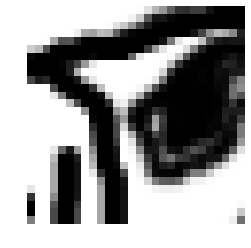

[0. 0. 0. ... 0. 0. 0.]


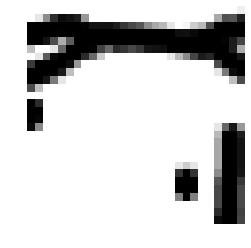

[0. 0. 0. ... 0. 0. 0.]


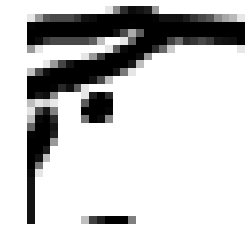

[0. 0. 0. ... 0. 0. 0.]


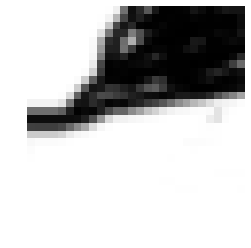

[0. 0. 0. ... 0. 0. 0.]


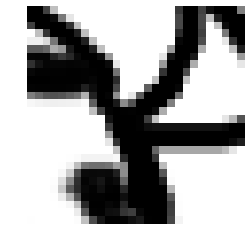

[0. 0. 0. ... 0. 0. 0.]


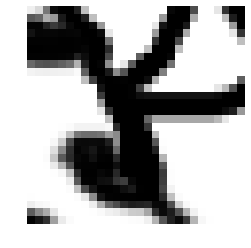

[0. 0. 0. ... 0. 0. 0.]


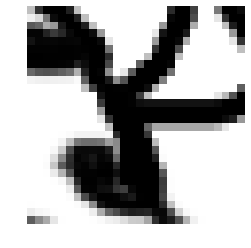

[0. 0. 0. ... 0. 0. 0.]


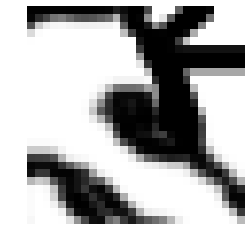

[0. 0. 0. ... 0. 0. 0.]


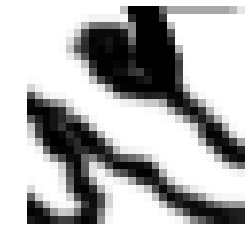

[0. 0. 0. ... 0. 0. 0.]


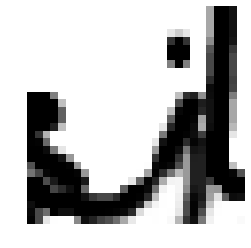

[0. 0. 0. ... 0. 0. 0.]
7840
epoch       main/loss   validation/main/loss  main/rec_loss  validation/main/rec_loss  elapsed_time
1           544.82      539.868               542.668        533.577                   6.98191       
2           534.96      526.85                529.448        523.874                   12.2497       
3           526.127     523.22                523.496        521.219                   18.5235       
4           521.076     517.744               519            515.581                   23.1665       
5           512.516     507.598               510.38         505.282                   29.52         
6           507.863     516.67                505.328        513.625                   34.7397       
7           508.539     499.526               505.414        496.505                   41.6413       
8           500.64      497.836               497.586        494.798                   47.0917       
9           495.302     492.871               492.091  

81          209.809     350.067               204.494        344.929                   529.239       
82          209.242     348.054               203.979        342.968                   534.388       
83          207.042     349.573               201.798        344.485                   542.197       
84          205.426     346.034               200.195        340.977                   547.675       
85          204.101     346.966               198.862        341.893                   554.815       
86          202.113     346.05                196.863        340.984                   560.09        
87          200.864     347.35                195.64         342.29                    566.462       
88          199.92      346.903               194.664        341.822                   572.156       
89          198.01      347.49                192.761        342.41                    578.936       
90          197.527     348.458               192.274        343.36               

162         151.94      394.347               147.011        389.488                   1101.06       
163         151.665     395.873               146.741        391.024                   1108.64       
164         151.308     395.874               146.394        391.029                   1114.36       
165         151.097     395.11                146.184        390.258                   1120.59       
166         150.791     397.333               145.868        392.475                   1125.49       
167         150.461     396.04                145.544        391.188                   1132.68       
168         150.471     401.381               145.544        396.526                   1138.34       
169         150.46      398.333               145.554        393.485                   1145.07       
170         149.223     407.049               144.323        402.172                   1149.94       
171         149.981     406.264               145.083        401.431              

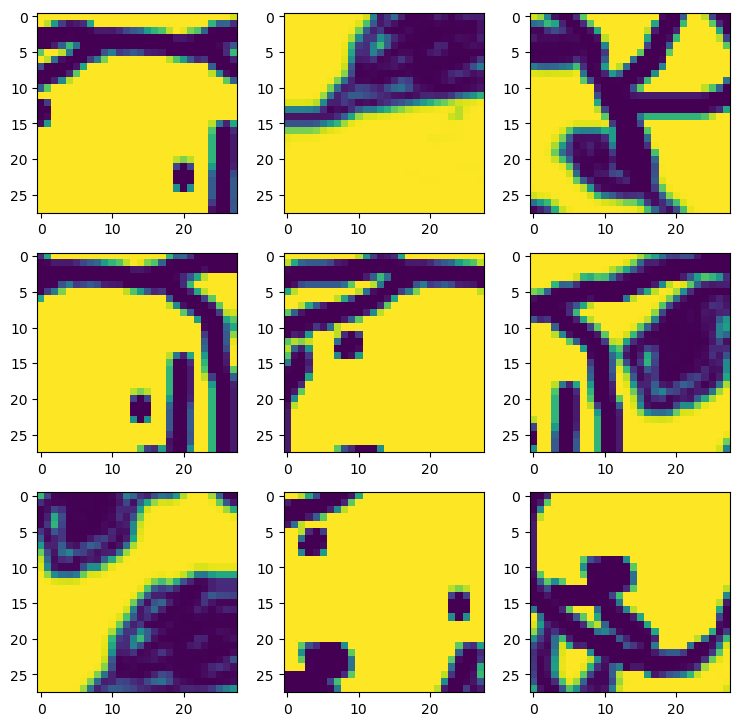

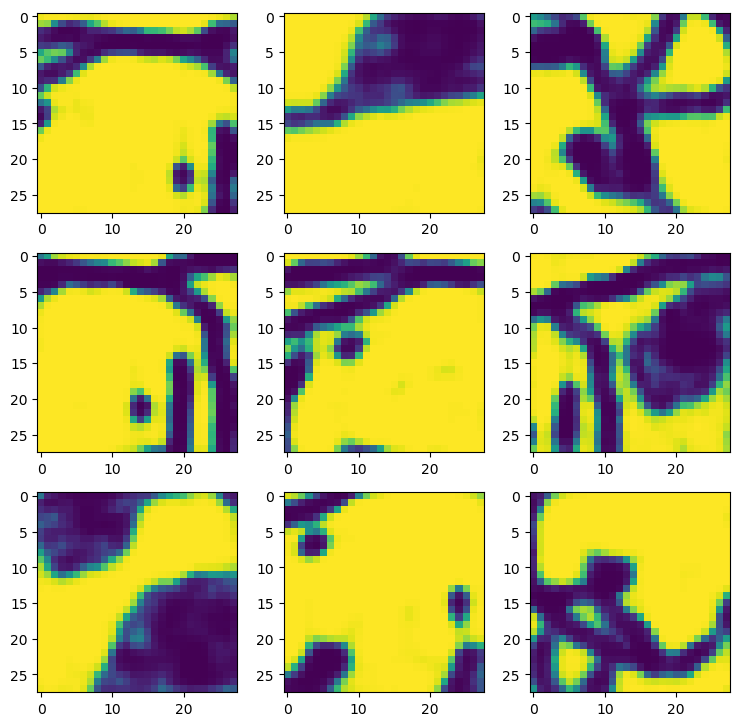

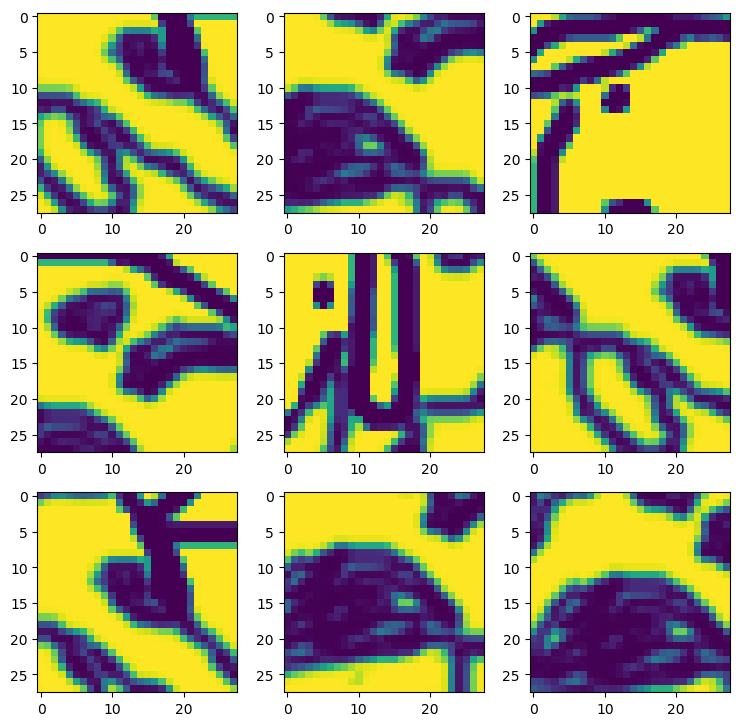

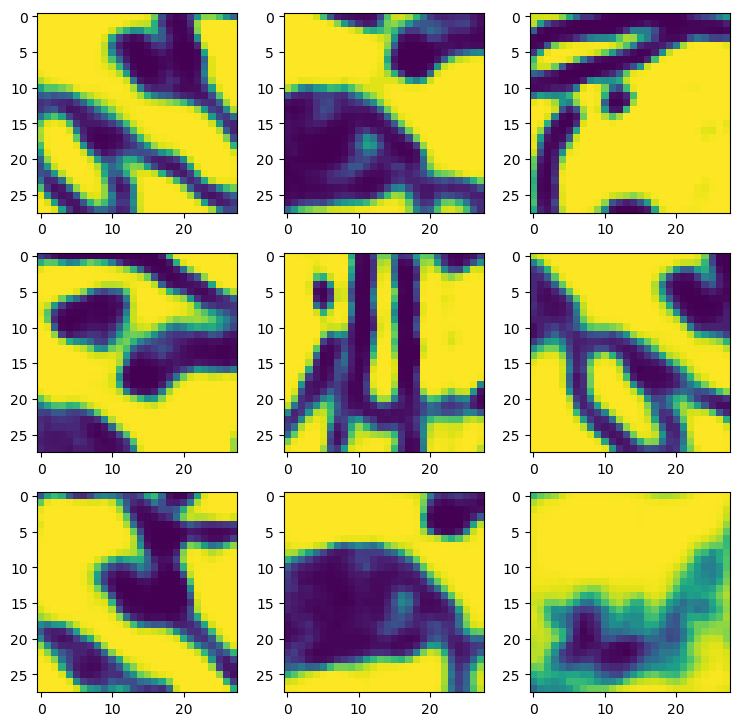

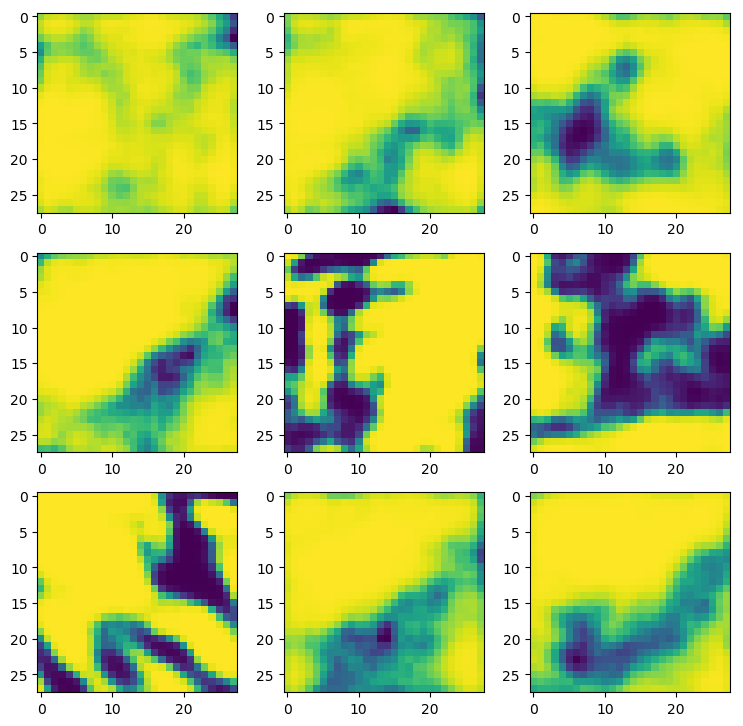

In [1]:
"""CVAE on MNIST
"""
import argparse
import os

import chainer
import pickle
import matplotlib.pyplot as plt
from chainer import training
from chainer.training import extensions
from PIL import Image, ImageDraw
import numpy as np

import net 
import make_random_mnist
import make_random_selfdata
from chainer import serializers
%matplotlib inline


NLABELDIM = 1
NZDIM = 2

def load_save_random_dataset_withlabel(fname, n):
    dataset = make_random_mnist.MakeRandomMNIST()
    if os.path.exists(fname):
        with open(fname, mode='rb') as f:
            ret = pickle.load(f)
            return ret
    v = dataset.get_random_dataset_with_label(n)
    with open(fname, mode='wb') as f:
        pickle.dump(v, f)
        return v

def dispImage(img_vec):
    #title = 'Label number is ('+ str(label_x) + ',' + str(label_y) + ')' 
    pixels = (img_vec * 256).reshape((28, 28))
    plt.imshow(pixels, cmap='gray')
    plt.axis("off")
    #plt.title(title)
    plt.show()

def main():
    global NLABELDIM, NZDIM
    parser = argparse.ArgumentParser(description='Chainer example: VAE')
    parser.add_argument('--initmodel', '-m', default='',
                        help='Initialize the model from given file')
    parser.add_argument('--resume', '-r', default='',
                        help='Resume the optimization from snapshot')
    parser.add_argument('--gpu', '-g', default=-1, type=int,
                        help='GPU ID (negative value indicates CPU)')
    parser.add_argument('--out', '-o', default='result',
                        help='Directory to output the result')
    parser.add_argument('--epoch', '-e', default=200, type=int,
                        help='number of epochs to learn')
    parser.add_argument('--dimz', '-z', default=2, type=int,
                        help='dimention of encoded vector')
    parser.add_argument('--batchsize', '-b', type=int, default=1200,
                        help='learning minibatch size')
    parser.add_argument('--test', action='store_true',
                        help='Use tiny datasets for quick tests')
    args = parser.parse_args(args=['-g -1'])

    print('GPU: {}'.format(args.gpu))
    print('# dim z: {}'.format(args.dimz))
    print('# Minibatch-size: {}'.format(args.batchsize))
    print('# epoch: {}'.format(args.epoch))
    print('')


    # Load the MNIST dataset
    #train, test = chainer.datasets.get_mnist()
    #train = load_save_random_dataset_withlabel('random_wlabel_train.pickle', 60000)
    #test = load_save_random_dataset_withlabel('random_wlabel_test.pickle', 10000)
    
    #dataset = make_random_mnist.MakeRandomMNIST()
    #train = dataset.get_random_dataset_with_hot_vector(60000)
    #test = dataset.get_random_dataset_with_hot_vector(1000)

    #train = load_save_random_dataset_withlabel('imu_axislabel_train.pickle', 10000)
    #test = load_save_random_dataset_withlabel('inu_axislabel_test.pickle', 6000)
    
    #img = '../images/chizu_naga.png'
    img = '../images/inu.png'
    dataset = make_random_selfdata.MakeRandomSelfdata(img)
    #train = dataset.get_random_dataset_with_label(3000)
    #test = dataset.get_random_dataset_with_label(1000)
    
    #train = dataset.get_random_dataset_with_hot_vector(3000)
    #test = dataset.get_random_dataset_with_hot_vector(1000)
    
    #train = dataset.get_random_dataset_with_x_coordinate(3000)
    #test = dataset.get_random_dataset_with_x_coordinate(1000)
    
    
    train = dataset.get_random_dataset_with_hot_vector_2d(3000)
    test = dataset.get_random_dataset_with_hot_vector_2d(1000)
    
    train = dataset.get_random_dataset_with_one_hot_vector_2d(3000)
    test = dataset.get_random_dataset_with_one_hot_vector_2d(1000)
    #print('-------------------------------------------')
    for t in range(10):
        dispImage(train[t][0])
        print(train[t][1])
    
    NLABELDIM = len(train[0][1])
    print(NLABELDIM)

    if args.test:
        train, _ = chainer.datasets.split_dataset(train, 100)
        test, _ = chainer.datasets.split_dataset(test, 100)

    train_iter = chainer.iterators.SerialIterator(train, args.batchsize)
    test_iter = chainer.iterators.SerialIterator(test, args.batchsize,
                                                 repeat=False, shuffle=False)

    # Prepare CVAE model, defined in net.py
    NZDIM = args.dimz
    model = net.MyCVAE(784, args.dimz, 500, NLABELDIM)

    # Setup an optimizer
    optimizer = chainer.optimizers.Adam()
    optimizer.setup(model)

    # Initialize
    if args.initmodel:
        chainer.serializers.load_npz(args.initmodel, model)

    # Set up an updater. StandardUpdater can explicitly specify a loss function
    # used in the training with 'loss_func' option
    updater = training.updaters.StandardUpdater(
        train_iter, optimizer,
        device=args.gpu, loss_func=model.get_loss_func())

    trainer = training.Trainer(updater, (args.epoch, 'epoch'), out=args.out)
    trainer.extend(extensions.Evaluator(test_iter, model, device=args.gpu,
                                        eval_func=model.get_loss_func(k=10)))
    trainer.extend(extensions.dump_graph('main/loss'))
    trainer.extend(extensions.snapshot(), trigger=(20, 'epoch'))
    trainer.extend(extensions.LogReport())
    trainer.extend(extensions.PrintReport(
        ['epoch', 'main/loss', 'validation/main/loss',
         'main/rec_loss', 'validation/main/rec_loss', 'elapsed_time']))
    #trainer.extend(extensions.ProgressBar())

    if args.resume:
        chainer.serializers.load_npz(args.resume, trainer)

    # Run the training
    trainer.run()

    # Visualize the results
    def save_images(x, filename):
        import matplotlib.pyplot as plt
        fig, ax = plt.subplots(3, 3, figsize=(9, 9), dpi=100)
        for ai, xi in zip(ax.flatten(), x):
            ai.imshow(xi.reshape(28, 28))
        fig.savefig(filename)

    model.to_cpu()
    serializers.save_npz("mymodel_final.npz", model)

    train_ind = [1, 3, 5, 10, 2, 0, 13, 15, 17]
    xin = np.empty((0, 28*28), np.float32)
    xout = np.empty((0, 28*28), np.float32)
    for ind in train_ind:
        x, t = train[ind]
        x = np.expand_dims(x, axis=0)
        t = np.expand_dims(t.astype(np.float32), axis=0)
        #t = np.eye(NLABELDIM, dtype=np.float32)[t * NLABELDIM]
        with chainer.using_config('train', False), chainer.no_backprop_mode():
            x1 = model(x, np.expand_dims(t, axis=0))
            xin = np.append(xin, x, axis=0)
            xout = np.append(xout, x1.data, axis=0)

    save_images(xin, os.path.join(args.out, 'train'))
    save_images(xout, os.path.join(args.out, 'train_reconstructed'))

    test_ind = [3, 2, 1, 18, 4, 8, 11, 17, 61]
    xin = np.empty((0, 28*28), np.float32)
    xout = np.empty((0, 28*28), np.float32)
    for ind in test_ind:
        x, t = test[ind]
        x = np.expand_dims(x, axis=0)
        t = np.expand_dims(t.astype(np.float32), axis=0)
        #t = np.eye(NLABELDIM, dtype=np.float32)[t * NLABELDIM]
        with chainer.using_config('train', False), chainer.no_backprop_mode():
            x1 = model(x, np.expand_dims(t, axis=0))
            xin = np.append(xin, x, axis=0)
            xout = np.append(xout, x1.data, axis=0)

    save_images(xin, os.path.join(args.out, 'test'))
    save_images(xout, os.path.join(args.out, 'test_reconstructed'))

    # draw images from randomly sampled z
    z = chainer.Variable(np.random.normal(0, 1, (9, args.dimz)).astype(np.float32))
    #z = chainer.Variable(np.zeros((9, args.dimz), dtype=np.float32))

    #values = np.eye(NLABELDIM, dtype=np.float32)[range(9)]
    labels = np.linspace(0, 0.9, 9, dtype=np.float32) * NLABELDIM
    labels = labels.astype(dtype=np.int32)
    values = np.eye(NLABELDIM, dtype=np.float32)[labels]
    x = model.decode(z, np.expand_dims(values, axis=1))
    save_images(x.data, 'sampled')
    
if __name__ == '__main__':
    main()

In [2]:
# Visualize the results
def save_images(x, filename):
    import matplotlib.pyplot as plt
    fig, ax = plt.subplots(2, 5, figsize=(9, 9), dpi=100)
    for ai, xi in zip(ax.flatten(), x):
        ai.imshow(xi.reshape(28, 28))
    fig.savefig(filename)

model = net.MyCVAE(784, NZDIM, 500, NLABELDIM)
serializers.load_npz("mymodel_final.npz", model)

# draw images from randomly sampled z
z = chainer.Variable(np.random.normal(0, 1, (10, NZDIM)).astype(np.float32))
z = chainer.Variable(np.zeros((10, NZDIM), dtype=np.float32))


#values = np.eye(NLABELDIM, dtype=np.float32)[range(9)]
#pos = np.linspace(0.05, 0.85, 9, dtype=np.float32)
pos = np.linspace(0.1, 0.9, 9, dtype=np.float32)
print(pos)
labels = pos * NLABELDIM

labels = labels.astype(dtype=np.int32)
#values = np.eye(NLABELDIM, dtype=np.float32)[labels]     # one hot vector
#values = np.linspace(0.1, 0.9, 9, dtype=np.float32)       # label and coordinate
#'''
labels = np.zeros((10, 70), dtype=np.float32)
for c in range(2):
    for r in range(5):
        #print(r, c)
        lvec_r = np.eye(50, dtype=np.float32)[10*r+5]
        lvec_c = np.eye(20, dtype=np.float32)[10*c+5]
        #print(10*r,10*c)
        lvec = np.append(lvec_r, lvec_c)
        #print(lvec_r, lvec_c)
        labels[c*5+r, :] = lvec
#'''

values = labels
# values = np.delete(labels,0,0)
print('----------------------')
print(values.shape)
print(z.shape)
x = model.decode(z, np.expand_dims(values, axis=1))
save_images(x.data, 'sampled')

[0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9]
----------------------
(10, 70)
(10, 2)


InvalidType: 
Invalid operation is performed in: LinearFunction (Forward)

Expect: in_types[0].shape[1] == in_types[1].shape[1]
Actual: 70 != 7840

In [ ]:
#!/usr/bin/env python
"""Chainer example: train a VAE on MNIST
"""
import argparse
import os

import chainer
from chainer import training
from chainer.training import extensions
import numpy as np

import net
import make_random_mnist
import pickle

def load_random_dataset_nolabel():
    with open('random_dataset.pickle', mode='rb') as f:
        ret = pickle.load(f)
        return ret

def save_random_dataset_nolabel( v):
    with open('random_dataset.pickle', mode='wb') as f:
        pickle.dump(v, f)
        
def main():
    parser = argparse.ArgumentParser(description='Chainer example: VAE')
    parser.add_argument('--initmodel', '-m', default='',
                        help='Initialize the model from given file')
    parser.add_argument('--resume', '-r', default='',
                        help='Resume the optimization from snapshot')
    parser.add_argument('--gpu', '-g', default=-1, type=int,
                        help='GPU ID (negative value indicates CPU)')
    parser.add_argument('--out', '-o', default='result',
                        help='Directory to output the result')
    parser.add_argument('--epoch', '-e', default=100, type=int,
                        help='number of epochs to learn')
    parser.add_argument('--dimz', '-z', default=20, type=int,
                        help='dimention of encoded vector')
    parser.add_argument('--batchsize', '-b', type=int, default=1200,
                        help='learning minibatch size')
    parser.add_argument('--test', action='store_true',
                        help='Use tiny datasets for quick tests')
    args = parser.parse_args(args = ['-g -1'])

    print('GPU: {}'.format(args.gpu))
    print('# dim z: {}'.format(args.dimz))
    print('# Minibatch-size: {}'.format(args.batchsize))
    print('# epoch: {}'.format(args.epoch))
    print('')

    # Prepare VAE model, defined in net.py
    model = net.VAE(784, args.dimz, 2000)

    # Setup an optimizer
    optimizer = chainer.optimizers.Adam()
    optimizer.setup(model)

    # Initialize
    if args.initmodel:
        chainer.serializers.load_npz(args.initmodel, model)

    # Load the MNIST dataset
    train, test = chainer.datasets.get_mnist(withlabel=False)
    dataset = make_random_mnist.MakeRandomMNIST()
    #train = dataset.get_random_dataset_nolabel(60000)
    #save_random_dataset_nolabel(train)
    train = load_random_dataset_nolabel()
    print(train.shape)

    if args.test:
        train, _ = chainer.datasets.split_dataset(train, 100)
        test, _ = chainer.datasets.split_dataset(test, 100)

    train_iter = chainer.iterators.SerialIterator(train, args.batchsize)
    test_iter = chainer.iterators.SerialIterator(test, args.batchsize,
                                                 repeat=False, shuffle=False)

    # Set up an updater. StandardUpdater can explicitly specify a loss function
    # used in the training with 'loss_func' option
    updater = training.updaters.StandardUpdater(
        train_iter, optimizer,
        device=args.gpu, loss_func=model.get_loss_func())
    #updater = training.updaters.ParallelUpdater(train_iter, optimizer, devices={'main': 0, 'second': 1})

    trainer = training.Trainer(updater, (args.epoch, 'epoch'), out=args.out)
    trainer.extend(extensions.Evaluator(test_iter, model, device=args.gpu,
                                        eval_func=model.get_loss_func(k=10)))
    trainer.extend(extensions.dump_graph('main/loss'))
    trainer.extend(extensions.snapshot(), trigger=(args.epoch, 'epoch'))
    trainer.extend(extensions.LogReport())
    trainer.extend(extensions.PrintReport(
        ['epoch', 'main/loss', 'validation/main/loss',
         'main/rec_loss', 'validation/main/rec_loss', 'elapsed_time']))
    #trainer.extend(extensions.ProgressBar())

    if args.resume:
        chainer.serializers.load_npz(args.resume, trainer)

    # Run the training
    trainer.run()

    # Visualize the results
    def save_images(x, filename):
        import matplotlib.pyplot as plt
        fig, ax = plt.subplots(3, 3, figsize=(9, 9), dpi=100)
        for ai, xi in zip(ax.flatten(), x):
            ai.imshow(xi.reshape(28, 28))
        fig.savefig(filename)

    model.to_cpu()
    train_ind = [1, 3, 5, 10, 2, 0, 13, 15, 17]
    x = chainer.Variable(np.asarray(train[train_ind]))
    with chainer.using_config('train', False), chainer.no_backprop_mode():
        x1 = model.decode(model.encode(x)[0])
    save_images(x.data, os.path.join(args.out, 'train'))
    save_images(x1.data, os.path.join(args.out, 'train_reconstructed'))

    test_ind = [3, 2, 1, 18, 4, 8, 11, 17, 61]
    x = chainer.Variable(np.asarray(test[test_ind]))
    with chainer.using_config('train', False), chainer.no_backprop_mode():
        x1 = model.decode(model.encode(x)[0])
    save_images(x.data, os.path.join(args.out, 'test'))
    save_images(x1.data, os.path.join(args.out, 'test_reconstructed'))

    # draw images from randomly sampled z
    z = chainer.Variable(
        np.random.normal(0, 1, (9, args.dimz)).astype(np.float32))
    x = model.decode(z)
    save_images(x.data, os.path.join(args.out, 'sampled'))


if __name__ == '__main__':
    main()
